# Projet d'Incertitudes : modélisation d'un flux de voitures

On utilise l'équation de Burgers pour le transport non linéaire:

$$
\partial_t \rho + \partial_x (\rho v(\rho)) = 0
$$

avec

- $\rho$ la densité de voitures
- $v(\rho) = v_{max}(1-\frac{\rho}{\rho_{max}} )$ la vitesse des voitures en fonction de la densité
- $\rho_{max}$ la densité maximale de voitures, on suppose $\rho_{max}=1$
- $v_{max}$ la vitesse maximale sur la route

On prend comme condition initiale un problème de Riemann de la forme:

$$
\rho(0,x) = \begin{cases}
r_{in} \quad ,x < x_C \\
r_{out} \quad ,x > x_C
\end{cases}
$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy as cp
import openturns as ot
from joblib import Parallel, delayed
import torch
import torch.nn as nn
import shap

In [2]:
class Burgers:
    def __init__(self, Nx, xC, rout, vmax):
        self.Nx = Nx  # nb mailles
        self.a = 0.0  # bord gauche du domaine
        self.b = 1.0  # bord droit du domaine
        self.dt = 0.0
        self.h = (self.b - self.a) / self.Nx  # pas de maillage
        self.begin = 1  # numéro de la première maille non fantome
        self.end = self.Nx + 1  # numéro de la dernière maille non fantome
        self.nodes = np.linspace(self.a - self.h, self.b + self.h, self.Nx + 3)
        self.cells = np.linspace(
            self.a - 0.5 * self.h, self.b + 0.5 * self.h, self.Nx + 2
        )
        self.rho = np.zeros(self.Nx + 2)  ## rho sur le maillage + mailles fantomes

        # Paramètres spécifiques du modèle
        self.xC = xC  # Position de la transition de densité
        self.rout = rout  # Densité après xC
        self.rhomax = 1.0  # Densité maximale, renormalisée à 1
        self.vmax = vmax

    # fonction pour initialiser rho
    def init(self, rin):
        for i in range(0, len(self.rho)):
            if self.cells[i] < self.xC:
                self.rho[i] = rin  # Densité avant xC
            else:
                self.rho[i] = self.rout  # Densité après xC

        # on conserve le rho initiale
        self.rho_0 = cp.copy(self.rho)

    # flux volumes finis de Lax-Friedrichs
    def flux_hyp(self, rl, rr):
        vl = self.vmax * (1.0 - rl / self.rhomax)
        vr = self.vmax * (1.0 - rr / self.rhomax)
        center = 0.5 * (0.5 * rl * vl + 0.5 * rr * vr)
        vel = max(
            abs(self.vmax * (1.0 - 2.0 * rl / self.rhomax)),
            abs(self.vmax * (1.0 - 2.0 * rr / self.rhomax)),
        )
        visco = 0.5 * vel * (rl - rr)
        return center + visco

    # plot de rho_0 et de rho
    def plot(self):
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        axes[0].plot(
            self.cells[self.begin : self.end], self.rho_0[self.begin : self.end], "ro-"
        )
        axes[1].plot(
            self.cells[self.begin : self.end], self.rho[self.begin : self.end], "bo-"
        )
        axes[0].set_title(f"Initial density")
        axes[1].set_title(f"Density at time T")
        axes[0].ticklabel_format(axis="y", style="sci", useOffset=False)
        axes[1].ticklabel_format(axis="y", style="sci", useOffset=False)
        plt.tight_layout()
        plt.show()

    # condition limite dans les mailles fantomes selon le cas test. A expliquer
    def bc(self):
        self.rho[0] = self.rho[1]
        self.rho[-1] = self.rho[-2]

    # Résolution de l'équation en temps
    def solve(self, T, jam=False):
        nt = 0
        time = 0.0
        rho_temp = np.zeros(self.Nx)
        while time < T:
            # vitesse max de l'équation utile pour CFL
            vmax = max(
                abs(
                    self.vmax
                    * (1.0 - 2.0 * self.rho[self.begin : self.end] / self.rhomax)
                )
            )
            if vmax == 0:
                vmax += 1e-6
            self.cfl = vmax * self.dt / self.h
            self.dt = 0.5 * self.h / vmax
            self.bc()
            for i in range(0, self.Nx):
                # calcul des conditions limites dans la mailles fantomes
                rhol = self.rho[self.begin + i - 1]
                rhoc = self.rho[self.begin + i]
                rhor = self.rho[self.begin + i + 1]
                # calcul des flux explicite
                fh = self.flux_hyp(rhoc, rhor) - self.flux_hyp(rhol, rhoc)
                # schéma en temps explicite
                rho_temp[i] = rhoc - self.dt / self.h * fh.squeeze()

            self.rho[self.begin : self.end] = rho_temp
            time = time + self.dt
            nt = nt + 1

            if jam:
                grad_rho = np.diff(self.rho) / self.h  # Dérivée de rho
                max_grad_rho = np.max(np.abs(grad_rho))  # Maximum absolu de la dérivée
                if (
                    np.abs(self.rho[0] - self.rho[-1]) < 0.01
                    or max_grad_rho < 2
                    or self.rho[0] > self.rho[-1]
                ):
                    # print(f"Le choc s'est lissé apres {time} secondes")
                    return time
        return time

cfl: 0.4999990679894911


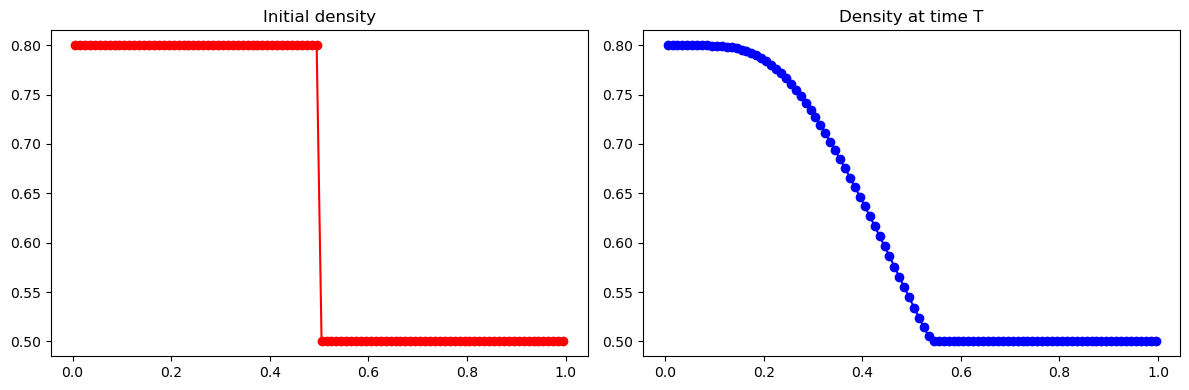

In [3]:
Nx = 100  # Nombre de mailles
xC = 0.5  # Position de la transition de densité
rout = 0.5  # Densité après xC
rin = 0.8  # Densité avant xC

vmax = np.random.normal(0.8, 0.03, 1)
r_R = np.random.uniform(0.2, 0.35, 1)

model = Burgers(Nx, xC, rout, vmax)
model.init(rin)
model.solve(T=1.0)
print(f"cfl: {model.cfl}")  # Stable si < 1
model.plot()

## 2. Intrervalles de confiance


In [4]:
# On aurait put utiliser openTurns pour les distri mais au temps tout faire en numpy ?


def monte_carlo_simulation(n_samples, Nx, xC, T, vmax_params, rin_params, rout_params):
    rho_samples = []
    for _ in range(n_samples):
        vmax = np.random.normal(*vmax_params)
        rin = np.random.uniform(*rin_params)
        rout = np.random.uniform(*rout_params)

        model = Burgers(Nx, xC, rout, vmax)
        model.init(rin)
        model.solve(T)
        rhoT = model.rho[1:-1]
        rho_samples.append(rhoT)
    return np.array(rho_samples)


# Paramètres de la simulation
Nx = 50  # Nombre de mailles
xC = 0.5  # Position de la transition de densité
T = 2.0  # Temps final

vmax_params = (0.8, 0.03)
rin_params = (0.2, 0.35)
rout_params = (0.5, 0.65)

rho_samples = monte_carlo_simulation(
    100, Nx, xC, T, vmax_params, rin_params, rout_params
)

# Calcul des quantiles
confidence_interval_lower = np.percentile(rho_samples, 2.5, axis=0)
confidence_interval_upper = np.percentile(rho_samples, 97.5, axis=0)
rho_mean = np.mean(rho_samples, axis=0)  # Moyenne sur les simulations -> plot

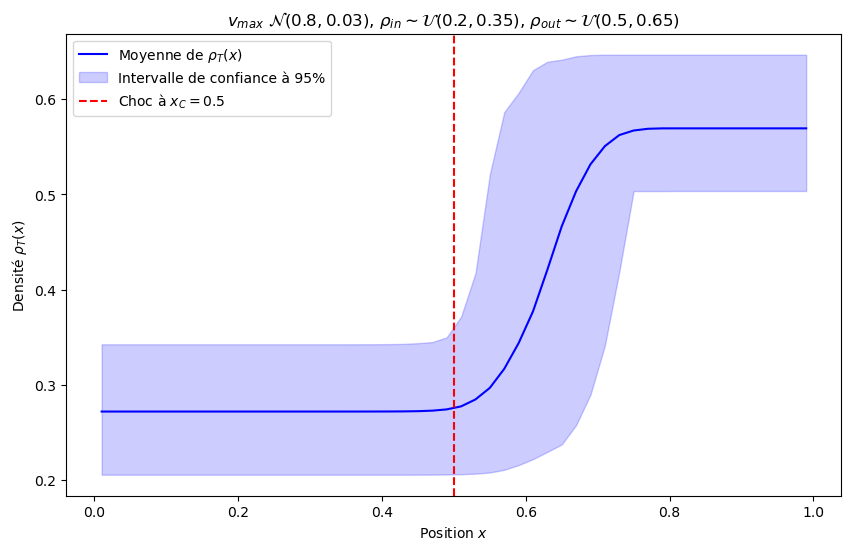

In [5]:
model = Burgers(Nx, xC, 0.6, 1) # juste pour avoir les x_values
x_values = model.cells[1:-1]

plt.figure(figsize=(10, 6))
plt.plot(x_values, rho_mean, label="Moyenne de $\\rho_T(x)$", color="blue")
plt.fill_between(
    x_values,
    confidence_interval_lower,
    confidence_interval_upper,
    color="blue",
    alpha=0.2,
    label="Intervalle de confiance à 95%",
)
plt.axvline(x=0.5, color="red", linestyle="--", label="Choc à $x_C = 0.5$")
plt.title(
    "$v_{max} ~ \mathcal{N}(0.8, 0.03)$, $\\rho_{in} \sim \mathcal{U}(0.2, 0.35)$, $\\rho_{out} \sim \mathcal{U}(0.5, 0.65)$"
)
plt.xlabel("Position $x$")
plt.ylabel("Densité $\\rho_T(x)$")
plt.legend()
plt.show()

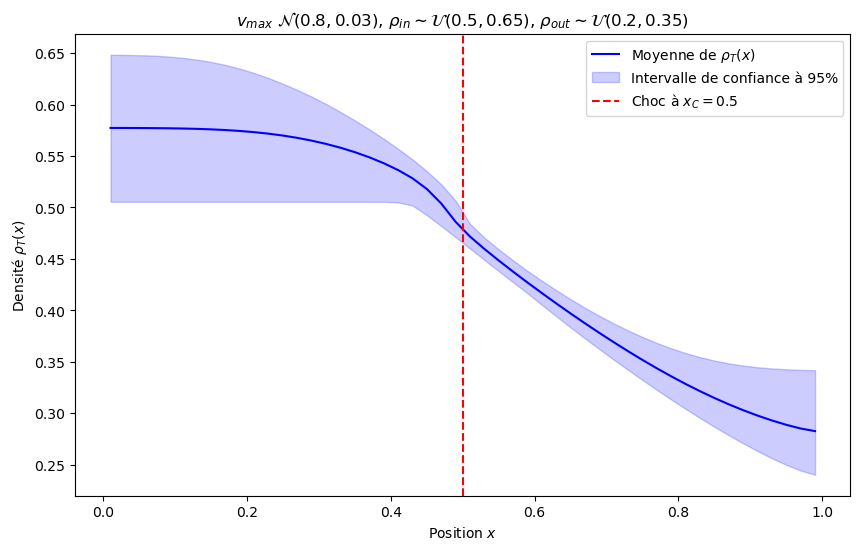

In [6]:
# En echangant rin et rout
rho_samples = monte_carlo_simulation(
    100, Nx, xC, T, vmax_params, rout_params, rin_params
)

# Calcul des quantiles
confidence_interval_lower = np.percentile(rho_samples, 2.5, axis=0)
confidence_interval_upper = np.percentile(rho_samples, 97.5, axis=0)
rho_mean = np.mean(rho_samples, axis=0)  # Moyenne sur les simulations

model = Burgers(Nx, xC, 0.6, vmax=1)
x_values = model.cells[1:-1]

plt.figure(figsize=(10, 6))
plt.plot(x_values, rho_mean, label="Moyenne de $\\rho_T(x)$", color="blue")
plt.fill_between(
    x_values,
    confidence_interval_lower,
    confidence_interval_upper,
    color="blue",
    alpha=0.2,
    label="Intervalle de confiance à 95%",
)
plt.axvline(x=0.5, color="red", linestyle="--", label="Choc à $x_C = 0.5$")
plt.title(
    "$v_{max} ~ \mathcal{N}(0.8, 0.03)$, $\\rho_{in} \sim \mathcal{U}(0.5, 0.65)$, $\\rho_{out} \sim \mathcal{U}(0.2, 0.35)$"
)
plt.xlabel("Position $x$")
plt.ylabel("Densité $\\rho_T(x)$")
plt.legend()
plt.show()

Quand $r_{in} > r_{out}$ dans le probleme de Riemann, on observe plutot une rarefaction au niveau de la discontinuité.


## 3. Lois limites

La loi limite de $\rho$ depend des condition initiales.  
Si $r_{in} < r_{out}$, i.e. la densité de voitures augmente au niveau de $x_C$ on va avoir un choc, et la solution sera de la forme

$$
\rho(t,x) = \begin{cases}
r_{in} \quad ,x < x_C  \\
\text{choc} \quad ,x = x_C \\
r_{out} \quad ,x > x_C
\end{cases}
$$

Si $r_{in} > r_{out}$, la densité de voitures diminue apres $x_C$, la circulation est plus fluide, on devrait avoir une rarefaction.

Si $r_{in} \approx r_{out}$, la solution devrait être plus ou moins constante.

En temps long il est possible que le choc se lisse (si vmax est suffisament grand?) et qu'on atteigne un point d'équilibre, dans ce cas là $r_{in} = r_{out}$ et $\rho_T = \frac{r_{in}}{v_{max}}$ et donc $\rho_T$ suit une loi log-normale


vmax=0.05


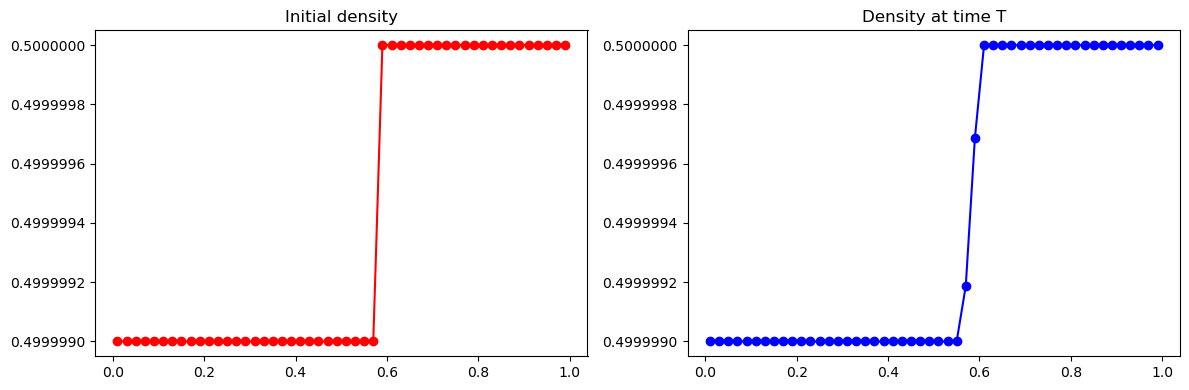

vmax=0.7


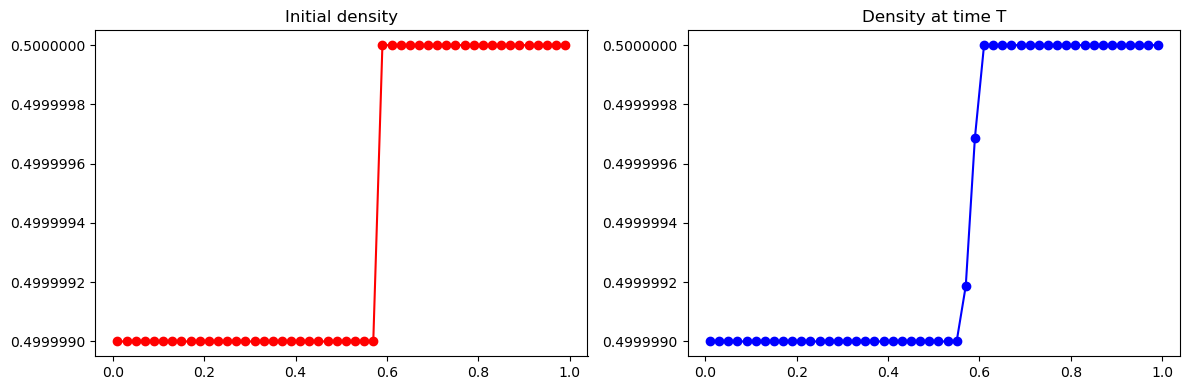

In [7]:
# Cas: rin ~ rout
vmax = [0.05, 0.7]
rin = 0.499999
rout = 0.5
xC = np.random.uniform(0.2, 0.8)

for v in vmax:
    model = Burgers(Nx, xC, rout, v)
    model.init(rin)
    model.solve(T=100)
    print(f"vmax={v}")
    model.plot()  # Il y tjs un choc mais tres petit

vmax=0.05


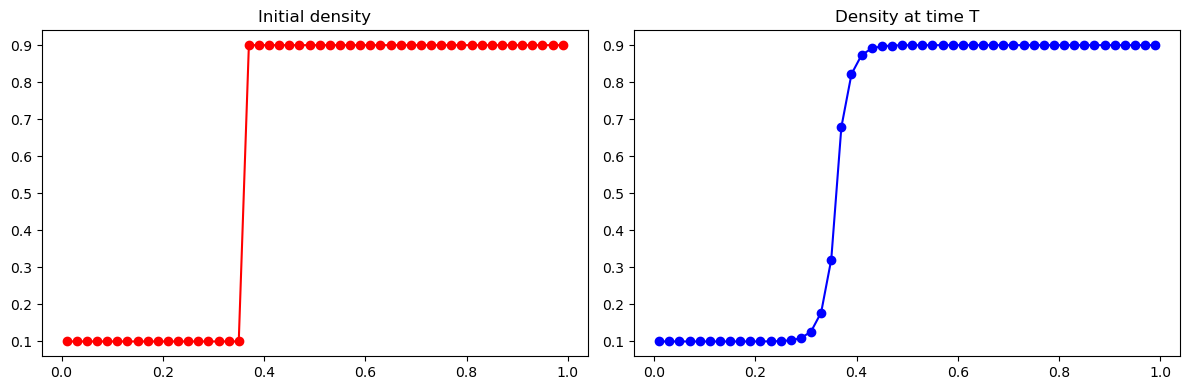

vmax=0.7


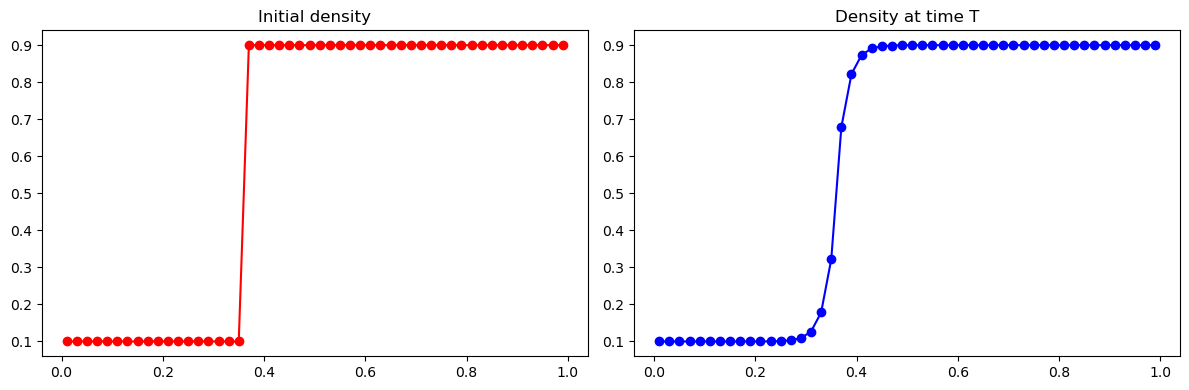

In [8]:
# Cas: rin << rout
vmax = [0.05, 0.7]
rin = 0.1
rout = 0.9
xC = np.random.uniform(0.2, 0.8)

for v in vmax:
    model = Burgers(Nx, xC, rout, v)
    model.init(rin)
    model.solve(T=100)
    print(f"vmax={v}")
    model.plot()  # le choc est beaucoup plus grand

vmax=0.05


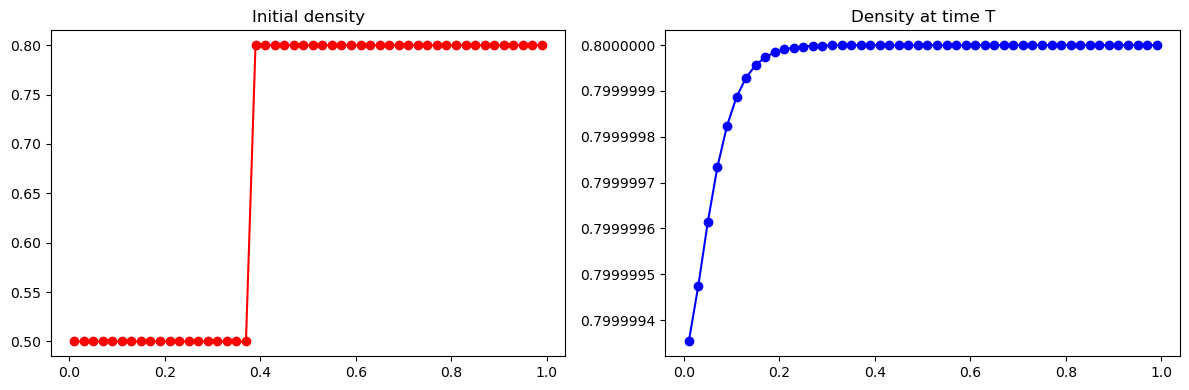

vmax=0.7


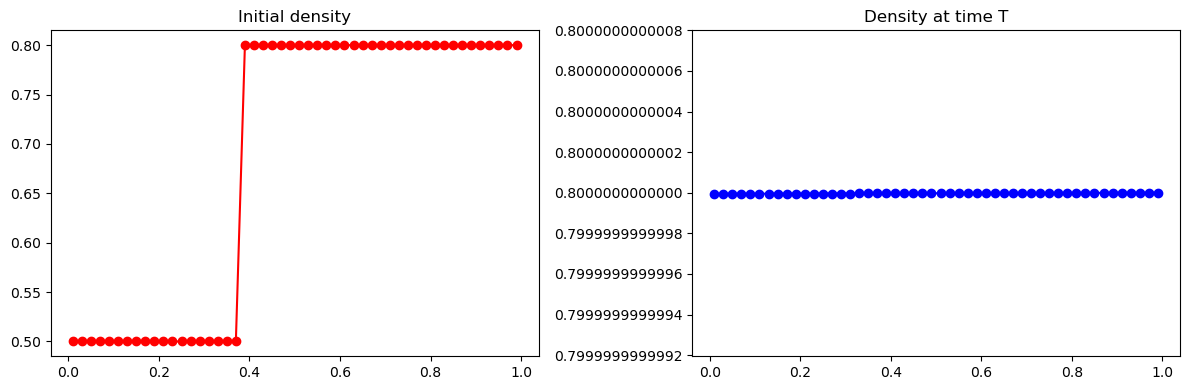

In [9]:
# Cas: rin < rout
vmax = [0.05, 0.7]
rin = 0.5
rout = 0.8
xC = np.random.uniform(0.2, 0.8)

for v in vmax:
    model = Burgers(Nx, xC, rout, v)
    model.init(rin)
    model.solve(T=100)
    print(f"vmax={v}")
    model.plot()

In [10]:
# random
# for _ in range(5):
# 	vmax = np.random.uniform(0.05, 0.7)
# 	rin = np.random.uniform(0.1, 0.5)
# 	rout = np.random.uniform(0.5, 0.9)
# 	xC = np.random.uniform(0.2, 0.8)
# 	model = Burgers(Nx, xC, rout, vmax)
# 	model.init(rin)
# 	model.solve(T=100)
# model.plot()

## 4. Temps necessaire pour que le bouchon se résorbe.

Qu'est-ce qui définie le bouchon ? **Choc** et densité élevé ? Vitesse nulle ?  
On cherche le temps qu'il faut pour le choc se lisse.  
Premiere idée :
$$ || \rho^{k} - \rho^{k-1} || < \epsilon $$
Mais si les deux solutions correspondent à des chocs ca ne va pas.

Deuxième idée :  
$$ \text{max} | \nabla \rho | < \epsilon $$
Pas de gradient trop élever = transition douce, pas de choc, pas de bouchon.

Mais si il y a une toute petite différence entre la densité de voiture à gauche et à droite du choc on pourrait considérer que ca n'est pas un bouchon, donc on peut avoir un gradient élevé sans que ca soit un bouchon?

Et si la densité de voiture est plus grande avant le choc, on n'a pas un bouchon mais une accélération.

On aurait aussi peut être put utiliser un critère sur la vitesse vu que celle ci est connue en tout point ($v(\rho) = v_{max}(1-\frac{\rho}{\rho_{max}} )$ )


In [11]:
V_dist = ot.Normal(0.8, 0.5)
V_dist.setDescription(["vmax"])
RIN_dist = ot.Uniform(0.1, 0.5)
RIN_dist.setDescription(["rin"])
ROUT_dist = ot.Uniform(0.5, 0.9)
ROUT_dist.setDescription(["rout"])
XC_dist = ot.Uniform(0.2, 0.8)
XC_dist.setDescription(["xC"])

inputDist = ot.ComposedDistribution([V_dist, RIN_dist, ROUT_dist, XC_dist])
inputRV = ot.RandomVector(inputDist)


def mySimulatlor(X):
    vmax, rin, rout, xc = X[0], X[1], X[2], X[3]
    model = Burgers(Nx=50, xC=xc, rout=rout, vmax=vmax)
    model.init(rin)
    time_resorption = model.solve(T=100, jam=True)
    # print(f"cfl: {model.cfl}")
    return [time_resorption]  # OpenTURNS attend une liste


g = ot.PythonFunction(4, 1, mySimulatlor)

In [12]:
outputVect = ot.CompositeRandomVector(g, inputRV)
montecarlosize = 500
outputSample = outputVect.getSample(montecarlosize)

Espérance de Y: 19.92
Variance de Y: 743.62
Ecart-type de Y: 27.27


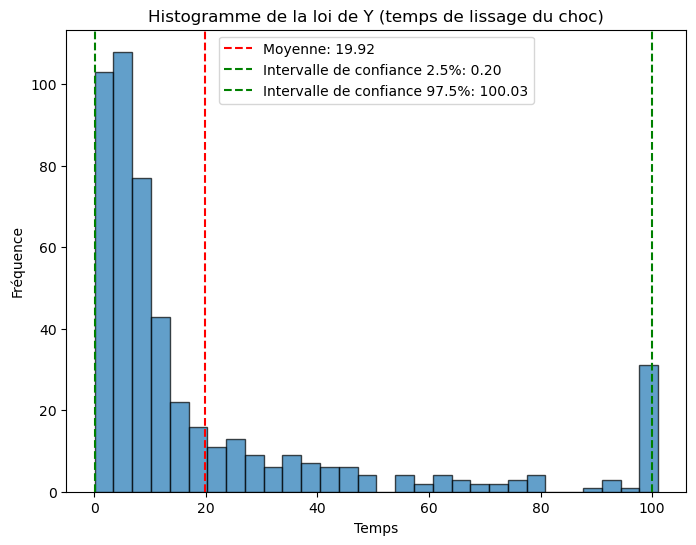

In [13]:
# Extraires les valeurs de Y
Y = np.array([outputSample[i, 0] for i in range(outputSample.getSize())])

mean_Y = np.mean(Y)
variance_Y = np.var(Y)
confidence_interval_lower = np.percentile(Y, 2.5)
confidence_interval_upper = np.percentile(Y, 97.5)

print(f"Espérance de Y: {mean_Y:.2f}")
print(f"Variance de Y: {variance_Y:.2f}")
print(f"Ecart-type de Y: {np.sqrt(variance_Y):.2f}")

plt.figure(figsize=(8, 6))
plt.hist(Y, bins=30, edgecolor="black", alpha=0.7)
plt.axvline(mean_Y, color="red", linestyle="--", label=f"Moyenne: {mean_Y:.2f}")
plt.axvline(
    confidence_interval_lower,
    color="green",
    linestyle="--",
    label=f"Intervalle de confiance 2.5%: {confidence_interval_lower:.2f}",
)
plt.axvline(
    confidence_interval_upper,
    color="green",
    linestyle="--",
    label=f"Intervalle de confiance 97.5%: {confidence_interval_upper:.2f}",
)
plt.title("Histogramme de la loi de Y (temps de lissage du choc)")
plt.xlabel("Temps")
plt.ylabel("Fréquence")
plt.legend()
plt.show()

Soit:

- les conditions initiales font que le choc ne se produit pas
- le choc se dissipe majoritairement rapidement
- le choc ne se dissipe pas en temps long (et probablement jamais)


## 5. Indices de Sobol

$$
S_i = \frac{Var(\mathbb{E}[Y|X_i])}{Var(Y)} \\
 S_{tot} = 1 - \frac{Var(Y|X_i)}{Var(Y)}
$$


In [14]:
size = 500
sie = ot.SobolIndicesExperiment(inputDist, size, False)
inputDesign = sie.generate()


# Parallelisation en utilisant joblib
def evaluate_model(i):
    return mySimulatlor(inputDesign[i, :])


outputSample = np.array(
    Parallel(n_jobs=-1)(
        delayed(evaluate_model)(i) for i in range(inputDesign.getSize())
    )
)

sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputSample, size)
firstOrderIndices = sensitivityAnalysis.getFirstOrderIndices()
totalOrderIndices = sensitivityAnalysis.getTotalOrderIndices()

print("First-order Sobol Indices:", firstOrderIndices)
print("Total-order Sobol Indices:", totalOrderIndices)

First-order Sobol Indices: [0.2601,0.0177154,0.0512211,0.0339191]
Total-order Sobol Indices: [0.414481,0.638229,0.603343,0.0893845]


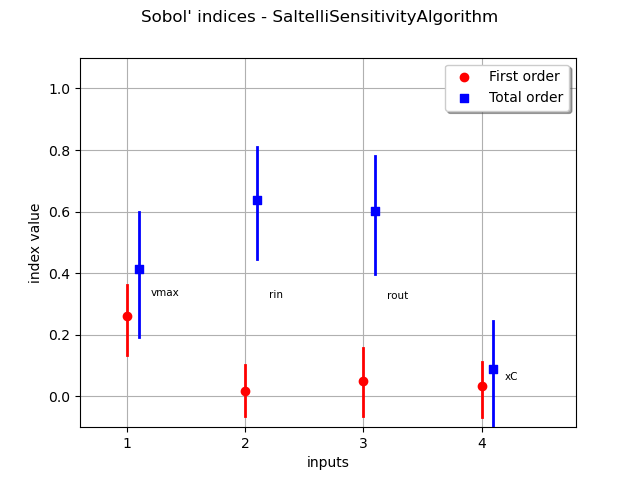

In [15]:
sensitivityAnalysis.draw()

- First order : impact individuel
- Total order : impact en prenant en compte les intéractions avec les autres variables

## 6. Meta-modèle


In [16]:
dim = 4  # number of inputs
R = ot.CorrelationMatrix(dim)
myCopula = ot.NormalCopula(ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(R))

sampleSize_train = 100
X_train = inputDist.getSample(sampleSize_train)
Y_train = g(X_train)

dimension = inputDist.getDimension()
basis = ot.ConstantBasisFactory(dimension).build()
# covarianceModel = ot.SquaredExponential([1.]*dimension, [1.0])
# covarianceModel.setScale(X_train.getMax())
lowerBounds = [0.01] * dimension
upperBounds = [5.8, 0.79, 0.79, 1.19]  # cf warning
initialScales = [0.5 * (low + up) for low, up in zip(lowerBounds, upperBounds)]
covarianceModel = ot.SquaredExponential(initialScales, [1.0])

algo = ot.KrigingAlgorithm(X_train, Y_train, covarianceModel, basis)
algo.run()
result = algo.getResult()
krigeageMM = result.getMetaModel()

WRN - Warning! For coherency we set scale upper bounds = [5.77167,0.794969,0.779859,1.18935]


Q2= [0.0783492]


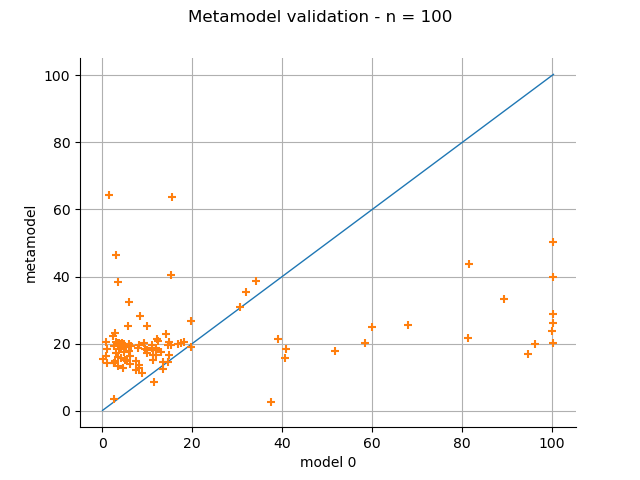

In [17]:
# Validation
sampleSize_test = 100
X_test = inputDist.getSample(sampleSize_test)
Y_test = g(X_test)
Y_test_MM = krigeageMM(X_test)
val = ot.MetaModelValidation(Y_test, Y_test_MM)

print("Q2=", val.computeR2Score())
val.drawValidation()

Trop mauvais pour être utilisé, surement à cause de la non-linéarité du problème.


In [18]:
# # Autre model
# sampleSize_train = 500
# X_train = inputDist.getSample(sampleSize_train)  # Training inputs
# Y_train = np.array(
#     [mySimulatlor(X_train[i, :]) for i in range(X_train.getSize())]
# )  # Model outputs

# inputSample = X_train
# outputSample = Y_train

# algo = ot.FunctionalChaosAlgorithm(inputSample, outputSample)
# algo.run()

# # Resultat du metamodel
# functionalChaosResult = algo.getResult()

# # Metamodel
# metamodel = functionalChaosResult.getMetaModel()

# # Test
# new_input = ot.Sample([[0.6, 0.2, 0.7, 0.5]])
# predicted_output = metamodel(new_input)

# print("Predicted output for new input:", predicted_output)

In [19]:
# n_valid = 100
# inputTest = inputDist.getSample(n_valid)
# outputTest = np.array([mySimulatlor(inputTest[i, :]) for i in range(n_valid)])
# metamodelPredictions = metamodel(inputTest)
# val = ot.MetaModelValidation(outputTest, metamodelPredictions)
# r2Score = val.computeR2Score()[0]
# r2Score

Essayons avec un meta-modele de type Réseau de Neurones:


In [20]:
# Générer les données d'entrée et de sortie pour l'entraînement du modèle MLP
def generate_training_data(num_samples=500):
    X_train = inputDist.getSample(num_samples)
    Y_train = np.array(
        [mySimulatlor(X_train[i, :]) for i in range(X_train.getSize())]
    )  # Temps de résorption
    return X_train, Y_train


X_train, Y_train = generate_training_data(500)

# Convertir les données en format PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)

In [21]:
class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation=nn.ReLU):
        super(MLPModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            activation(),
            nn.Linear(hidden_dim, hidden_dim),
            activation(),
            nn.Linear(hidden_dim, hidden_dim),
            activation(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        return self.model(x)

mlp = MLPModel(input_dim=4, hidden_dim=200, output_dim=1)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=800, gamma=0.5)

# Training 
num_epochs = 10000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = mlp(X_train_tensor) 

    loss = criterion(outputs.squeeze(), Y_train_tensor.squeeze()) 

    torch.nn.utils.clip_grad_norm_(mlp.parameters(), 1)
    loss.backward()
    optimizer.step()
    scheduler.step()

    print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}")
print(f"Epoch{num_epochs}, Loss: {loss.item():.4f}")

Epoch [0/10000], Loss: 1128.1371
Epoch [1/10000], Loss: 1075.3612
Epoch [2/10000], Loss: 956.6503
Epoch [3/10000], Loss: 805.7198
Epoch [4/10000], Loss: 880.8113
Epoch [5/10000], Loss: 822.6638
Epoch [6/10000], Loss: 749.5177
Epoch [7/10000], Loss: 747.3291
Epoch [8/10000], Loss: 757.2005
Epoch [9/10000], Loss: 747.0404
Epoch [10/10000], Loss: 716.7997
Epoch [11/10000], Loss: 683.7692
Epoch [12/10000], Loss: 676.4536
Epoch [13/10000], Loss: 695.1308
Epoch [14/10000], Loss: 686.6375
Epoch [15/10000], Loss: 659.9039
Epoch [16/10000], Loss: 652.7490
Epoch [17/10000], Loss: 661.7703
Epoch [18/10000], Loss: 667.5309
Epoch [19/10000], Loss: 662.5704
Epoch [20/10000], Loss: 652.7419
Epoch [21/10000], Loss: 650.5157
Epoch [22/10000], Loss: 658.7812
Epoch [23/10000], Loss: 660.7686
Epoch [24/10000], Loss: 652.6633
Epoch [25/10000], Loss: 647.9165
Epoch [26/10000], Loss: 650.2936
Epoch [27/10000], Loss: 652.5422
Epoch [28/10000], Loss: 649.9458
Epoch [29/10000], Loss: 644.7328
Epoch [30/10000], 

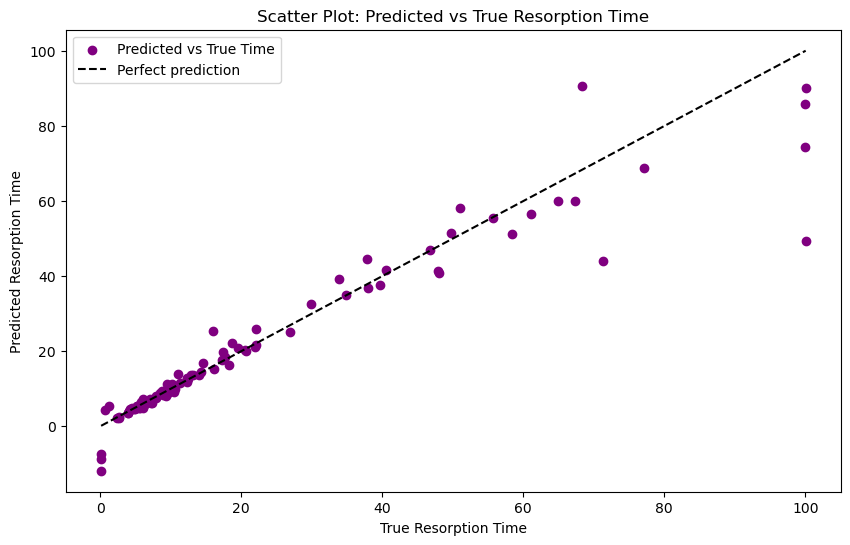

In [22]:
# Utiliser le modèle pour prédire le temps de résorption pour de nouvelles entrées
def predict_resorption_time(input_data):
    model_input = torch.tensor(input_data, dtype=torch.float32)
    with torch.no_grad():
        prediction = mlp(model_input)
    return prediction.numpy()


# Test
test_size = 100
v = np.random.normal(0.7, 0.05, test_size)
ri = np.random.uniform(0.1, 0.5, test_size)
ro = np.random.uniform(0.5, 0.9, test_size)
xc = np.random.uniform(0.2, 0.8, test_size)

test_inputs = np.concatenate(
    (v.reshape(-1, 1), ri.reshape(-1, 1), ro.reshape(-1, 1), xc.reshape(-1, 1)), axis=1
)

predicted_times = []
true_times = []

# Parcourir les différents cas de test
for input_data in test_inputs:
    predicted_time = predict_resorption_time(input_data.reshape(1, -1))
    true_time = mySimulatlor(input_data)

    predicted_times.append(predicted_time[0][0])
    true_times.append(true_time[0])


plt.figure(figsize=(10, 6))
plt.scatter(true_times, predicted_times, color="purple", label="Predicted vs True Time")
plt.plot(
    [min(true_times), max(true_times)],
    [min(true_times), max(true_times)],
    "k--",
    label="Perfect prediction",
)
plt.title("Scatter Plot: Predicted vs True Resorption Time")
plt.xlabel("True Resorption Time")
plt.ylabel("Predicted Resorption Time")
plt.legend()
plt.show()

Ca pourrait certainement être amélioré mais c'est quand même pas trop mal.

First-order Sobol Indices: [0.344021,0.0409234,0.0235655,0.00408669]
Total-order Sobol Indices: [0.550585,0.585486,0.54862,0.157273]


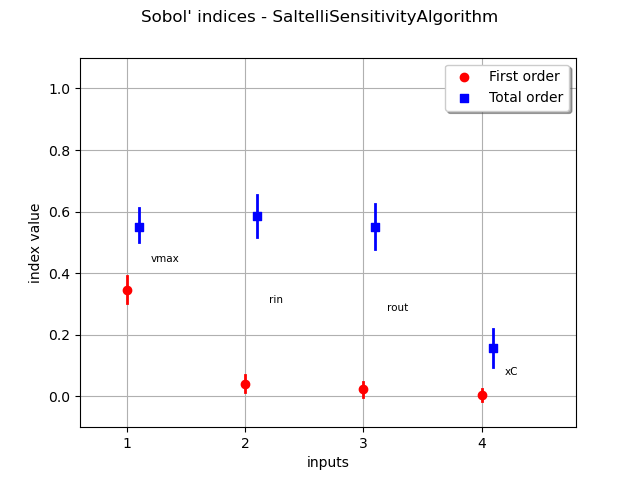

In [23]:
# Générer des échantillons pour l'analyse de sensibilité
sie = ot.SobolIndicesExperiment(inputDist, 10000, False)
inputDesign = sie.generate()


# Utiliser le MLP pour prédire les sorties
def evaluate_model_mlp(i):
    return predict_resorption_time(inputDesign[i, :])


# Effectuer l'analyse de sensibilité
outputSample = np.array([evaluate_model_mlp(i) for i in range(inputDesign.getSize())])

# Analyser les indices de Sobol
sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputSample, 10000)
firstOrderIndices = sensitivityAnalysis.getFirstOrderIndices()
totalOrderIndices = sensitivityAnalysis.getTotalOrderIndices()

print("First-order Sobol Indices:", firstOrderIndices)
print("Total-order Sobol Indices:", totalOrderIndices)
sensitivityAnalysis.draw()

Le meta-modèle est une "approximation" du modèle original et est donc plus rapide à calculer.  
On peut donc se permettre de faire plus de simulations pour avoir une meilleure estimation des indices de Sobol, on le voit très bien dans les intervalles de confiance.


## 7. Indices de Shapley


In [24]:
# Générer des échantillons pour l'analyse de sensibilité
size = 500
vmax = np.random.normal(0.7, 0.05, size)
rin = np.random.uniform(0.1, 0.5, size)
rout = np.random.uniform(0.5, 0.9, size)
xC = np.random.uniform(0.2, 0.8, size)

test_inputs = np.stack([vmax, rin, rout, xC], axis=1)

# Sample de taille 100 pour le background
background_data = shap.sample(test_inputs, 100)
# Utilise K=100 clusters
background_data = shap.kmeans(test_inputs, 100)

# Explainer SHAP
explainer = shap.KernelExplainer(
    lambda x: mlp(torch.tensor(x, dtype=torch.float32)).detach().numpy(),
    background_data,
)

# Calcul des indices de Shapley
shap_values = explainer.shap_values(test_inputs)

print(shap_values.shape)

  0%|          | 0/500 [00:00<?, ?it/s]

(500, 4, 1)


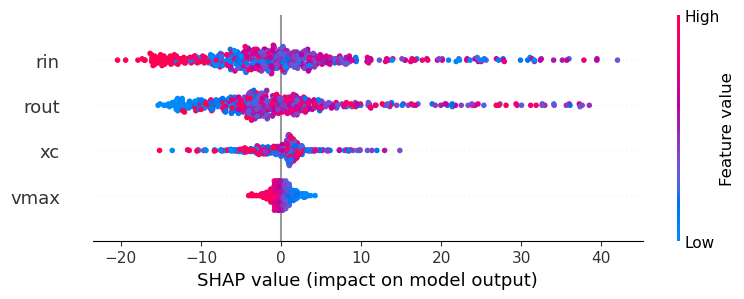

In [25]:
names = ["vmax", "rin", "rout", "xc"]
shap_values = shap_values.squeeze()
shap.summary_plot(shap_values, test_inputs, feature_names=names)

`rin` et `rout` semblent être les paramètres les plus importants.  

- Les valeurs élevées de `rin` réduisent le temps nécessaire pour que le choc se lisse (si rin est élevé, il y a plus de chances que $rin \approx rout$ car $max(rin) = min(rout) = 0$.5, et donc il n'y a pas de choc). Si rin est plus faible, cela a moins d'importance.

- Les valeurs faibles de `rout` réduisent le temps nécessaire pour que le choc se lisse (une densité plus faible après le choc facilite la circulation, donc ça roule mieux).

- Pour `xc` c'est assez confus, l'emplacement du choc dépend de notre point de vue en tant qu'observateur, à t'il vraiment un impact ?

- Les valeurs de `vmax` sont plutot centrées autour de 0, ce qui montre qu'elles n'ont pas une très grande importance, mais on remarque quand même qu'une plus grande valeur de `vmax` réduit le temps nécessaire pour que le choc se lisse, et inversement.

Résumé :

- **Sobol premier ordre** : mesure l'**impact individuel** d'une variable sur la variance de la sortie du modèle, en tenant compte uniquement de l'effet direct de cette variable, sans les interactions avec les autres variables.

- **Sobol total** : mesure l'**impact total** d'une variable, en tenant compte à la fois de son effet direct et de son effet par l'intermédiaire des interactions avec les autres variables, **sur l'ensemble de la variance du modèle.**

- **Shapley** : mesure la contribution de chaque variable à une **prédiction spécifique** du modèle, en tenant compte à la fois de son effet direct et de ses interactions avec les autres variables, mais sur une seule prédiction.